In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import gaussian_process
from astropy.timeseries import LombScargle
import random 
from scipy.stats import loguniform, gamma, uniform
import time 
import os
import pickle
from scipy import interpolate

# Functions

In [3]:
def lorentzian_components(params_gr, t):

    '''
    Simulated effects of pulsations and granulations
    
    source: Dumusque et al 2011
    https://www.aanda.org/articles/aa/pdf/2011/01/aa14097-10.pdf
    
    Inputs
        - params_gr := A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste
        - t = time in seconds

    ''' 
    
    # define frequency arrays  
    # The frequency ν goes from 1/T to the Nyquist frequency in steps of 1/T
    N    = len(t)
    Ttot = (max(t)-min(t)) # total time in seconds
    dt = np.median(np.diff(t)) # sampling rate
    freq_Nyq = (1.0/dt)/2 # Nyquist frequency
    freq  = np.arange(1.0/Ttot,freq_Nyq,1.0/Ttot, dtype='float64')
    # freq  = np.linspace(1.0/Ttot, 1./2/dt, len(t)) # Hz

    # define the power spectra as a sum of 3 components for granulation, mesogranulation and supergranulation + oscillations
    A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste = params_gr 
    
    VPSD = A1 / (1+(B1*freq)**C1) + A2 / (1+(B2*freq)**C2) +  A3 / (1+(B3*freq)**C3) + \
                AL * (Gm**2/((freq-nu0)**2+Gm**2)) +  cste  
    
    #VPSD /= 1e6     # units of VPSD is (m/s)**2/Hz
    VPSD *= (freq[-1] - freq[0])
           
    # take random phase between 0 and 2pi
    phase = 2*np.pi*np.random.rand(1,len(VPSD))
    #print(len(phase), len(VPSD))
    
    # Synthetic radial velocity measurements
    ysyn = np.zeros(N)
    for i in range(N):
        ysyn[i] = np.sum(np.sqrt(VPSD)*np.sin(2*np.pi*t[i]*freq+phase))
       
    return ysyn




def generate_data_H0(params_gr, params_act, t):
    
    '''
    Inputs:
    - params_gr:= 
            see function lorentzian_components(params_gr, t)
    - params_act:=
            - amplitude (GP amplitude)
            - gam = 2/epsilon in the paper (GP gamma)
            - logP = log(P) in the paper (GP period)
            - met = 1.0 in the paper (GP metric)
    
    - N = number of data points
        
    Outputs:
        - t = time (days)
        - y = RV (m/s)
        - yerr =  intrinsic errors (m/s)
    '''
    
    # =========================================================================
    # Generate a Lorentzian component that represents the pulsations and
    # three components for the granulation, mesogranulation and su-
    # pergranulation
    ts    = t*24*3600 # seconds
    ygr = lorentzian_components(params_gr, ts)
    
    # =========================================================================
    # Generate activity component based on GP
    
    # define the QP kernel for the GP (see https://george.readthedocs.io/en/latest/user/kernels/)
    tau, epsilon, Prot, amp = params_act
    k = gaussian_process.kernels.RBF(tau)
    k*= gaussian_process.kernels.ExpSineSquared(np.sqrt(epsilon),Prot)
    k*= amp**2
    
    gp = gaussian_process.GaussianProcessRegressor(k)
    t_gp = np.reshape(t, (t.shape[0],1))

    yact = gp.sample_y(t_gp, n_samples = 100)[:,np.random.randint(0,100)]
    
    
    # =========================================================================
    # Generate the intrincsic errors
    eb = np.random.normal(loc=3,scale=0.30, size=len(t)) # m/s
    if (any(eb < 0)) : eb = np.where(eb<0, 1.5, eb)
    yerr = np.random.normal(loc=0, scale=eb, size=len(t)) # this has to be defined according to the paper
    #print('std(yerr) = %f m/s'%np.std(yerr))

    # =========================================================================
    # Generate the final synthetic time series
    # activity + granulation + the intrinsic errors 
    ytot = ygr + yact + yerr * np.random.randn(len(t))
    
    return ytot, eb




def generate_planete(params_pl,t):
    """
    - params_pl
            - Ppl (Orbital period)
            - K (semi-amplitude)
            - T0 ( Phase à l'origine)
    """
    Ppl, K, T0 = params_pl
    return K*np.sin(2*np.pi*(t-T0)/Ppl)



def print_4periodogramme(LS,label,freq_pl):
    f1,f2,f3,f4 = freq_pl[:]
    l1,l2,l3,l4 = label[:]
    
    plt.figure()
    plt.suptitle("4 Lomb-Scargle peridogramme generated by removing the best fit\n")
    plt.subplot(411),plt.plot(freq, LS[:,0] , label =l1), plt.legend()
    if (f1!=0) : plt.plot([f1,f1] , [min(LS[:,0]),max(LS[:,0])],'r--')
    if (f2!=0) : plt.plot([f2,f2] , [min(LS[:,0]),max(LS[:,0])],'g--')
    if (f3!=0) : plt.plot([f3,f3] , [min(LS[:,0]),max(LS[:,0])],'b--')
    if (f4!=0) : plt.plot([f4,f4] , [min(LS[:,0]),max(LS[:,0])],'y--')

    plt.subplot(412), plt.plot(freq, LS[:,1] , label =l2), plt.legend()
    if (f1!=0) : plt.plot([f1,f1] , [min(LS[:,1]),max(LS[:,1])],'r--')
    if (f2!=0) : plt.plot([f2,f2] , [min(LS[:,1]),max(LS[:,1])],'g--')
    if (f3!=0) : plt.plot([f3,f3] , [min(LS[:,1]),max(LS[:,1])],'b--')
    if (f4!=0) : plt.plot([f4,f4] , [min(LS[:,1]),max(LS[:,1])],'y--')

    plt.subplot(413), plt.plot(freq, LS[:,2] , label =l3), plt.legend()
    if (f1!=0) : plt.plot([f1,f1] , [min(LS[:,2]),max(LS[:,2])],'r--')
    if (f2!=0) : plt.plot([f2,f2] , [min(LS[:,2]),max(LS[:,2])],'g--')
    if (f3!=0) : plt.plot([f3,f3] , [min(LS[:,2]),max(LS[:,2])],'b--')
    if (f4!=0) : plt.plot([f4,f4] , [min(LS[:,2]),max(LS[:,2])],'y--')

    plt.subplot(414 ), plt.plot(freq, LS[:,3] , label = l4), plt.legend()
    if (f1!=0) : plt.plot([f1,f1] , [min(LS[:,3]),max(LS[:,3])],'r--')
    if (f2!=0) : plt.plot([f2,f2] , [min(LS[:,3]),max(LS[:,3])],'g--')
    if (f3!=0) : plt.plot([f3,f3] , [min(LS[:,3]),max(LS[:,3])],'b--')
    if (f4!=0) : plt.plot([f4,f4] , [min(LS[:,3]),max(LS[:,3])],'y--')
    
    plt.xlabel("Frequency (day⁻¹)")
    plt.ylabel("Power")
    

def generate_4_periodograms(t,f, y, freq_pl,nbr_planete,eb):
    
    """
    Generated 4 Generalized Lomb-Scargle periodograms. Take the first time series given in input,
    calculate his GLS, removed the highest peak by fitting a sinusoide at this frequency and substract this 
    sinusoide to the time serie and calculate the GLS to the time series obtained. Repeat this processus 3 times.
    
    Input : 
        - t : time (day)
        - f : frequency ( day⁻1)
        - y : original time serie (m/s)
        - freq_pl : frequencies of exoplanet (day⁻¹)
        - nbr_planete : number of exoplanet in y 
        - eb : error bars (m/s)

    Output :
        - GLS : Generalized Lomb-Scragle periodograms 
        - Label : 1 if one of frequency of freq_pl is the max of the corresponding GLS, 0 either
        - max_value : Argmax and max of the corresponding GLS
        - nbr_planete_now : Number of planet in corresponding GLS 
    """
    
    y_t = np.zeros((len(t), 4)) #time series
    GLS  = np.zeros((len(f), 4)) # GLS
    label= np.zeros(4) #1 if max = freq_pl, 0 else
    max_value = np.zeros((2,4)) # (argmax, max)
    
    
    y_t[:,0] = np.copy(y) # first time serie is given as input
    
    #Loop to create GLS by removing highest peak
    for i in range(3):
        GLS_i =  LombScargle(t, y_t[:,i],eb) 
        GLS[:,i] = GLS_i.power(f,method='cython')
        best_freq = f[np.argmax(GLS[:,i])] # Frequency corresponding to the highest peak 
        max_value[0,i], max_value[1,i] = best_freq, np.max(GLS[:,i]) # ( Argmax, max)
        
        if ( any(np.isclose(freq_pl, best_freq, atol=0.002)) ): 
            # case where best_freq (max of GLS) is corresponding to any frequency planet
            label[i] = 1
            
            # Update the freq_pl and nbr_planete arrays
            ind_freq = np.where( np.isclose(freq_pl, best_freq, atol=0.002) )[0]
            freqs_found = freq_pl[ind_freq]
            ind_freq_found = np.argmin(np.abs(freqs_found - best_freq))
            freq_found = freqs_found[ind_freq_found]
            freq_pl[ np.where (freq_pl == freq_found)] = 0
            nbr_planete[i+1:] = nbr_planete[i] - 1
            
        else:
            # case where best_freq (max of GLS) isn't a frequency planet
            label[i] = 0
        
        # Generate a new time serie by take the ancient one and substract it a sinusoidale signal with frequency corresponding to the highest peak
        y_fit = GLS_i.model(t,best_freq)
        y_t[:,i+1] = y_t[:,i] - y_fit
    
    # Last GLS outside the loop for practical reason
    GLS_i = LombScargle(t, y_t[:,3],eb)
    GLS[:,3] = GLS_i.power(f,method='cython')
    best_freq = f[np.argmax(GLS[:,3])]
    max_value [0,3], max_value[1,3] =  best_freq, np.max(GLS[:,3])
    
    if (any(np.isclose(freq_pl, best_freq, atol=0.002))):
        label[3] = 1
    else:
        label[3] = 0
    
    
    return GLS, label, max_value    



def generate_data(t,dt,Ttot,freq,params_gr, nbr_pl_to_inject):
    
    """
    Generated 4 Generalized Lomb-Scargle periodogramm. Take the first time series given in input,
    calculate his GLS, removed the highest peak by fitting a sinusoide a this frequency and substract this 
    sinusoide to the time serie and calculate the GLS to the time series obtained. Repeat this processus 3 time.
    
    Input : 
        - t : time (day)
        - dt : median time interval (day)
        - Ttot : observation time (day)
        - freq : frequency ( day⁻1)
        - params_gr : see function lorentzian_components(params_gr, t)
        - nbr_pl_to_inject : number of exoplanet to inject in the simulation
        
    Output :
        - GLS : Generalized Lomb-Scragle periodograms 
        - Label : 1 if one of frequency of freq_pl is the max of the corresponding GLS, 0 either
        - max_value : Argmax and max of the corresponding GLS
        - freq_pl : frequencies of exoplanet (day⁻¹)
        - nbr_planete : Number of exoplanet in the corresponding GLS

    """
    
    GLS = np.zeros((len(freq),4)) 
    freq_pl = np.zeros(4)
    nbr_planete = np.zeros(4)
    label = np.zeros((4))
    max_value = np.zeros((2,4))
    
    # GP parameters, randomly chosen in distribution according to the paper
    Prot = random.randint(5,90)
    amp  = gamma.rvs(2.0, 0.5) 
    epsilon = uniform.rvs(0.5, 1)
    tau = np.random.normal(3*Prot, 0.1*Prot)
    params_act = [tau, epsilon, Prot, amp]
    
    # Generate H0 data, activity signal 
    y_noise, eb = generate_data_H0(params_gr, params_act, t)
    
    #Without planet 
    if ( nbr_pl_to_inject == 0): 
        GLS, label, max_value = generate_4_periodograms(t, freq, y_noise,freq_pl,nbr_planete,eb)
    
    #With planet
    else :
        y_i = y_noise
        # Loop to create a signal with nbr_pl_to_inject planets
        for i in range(1,nbr_pl_to_inject+1):
            # Planet signature parameters, randomly chosen according to the paper
            Ppl =  random.uniform(10*dt,Ttot/2) 
            K = loguniform.rvs(0.1, 10)
            T0 =  random.uniform(0,Ppl)
            params_pl = [Ppl,K,T0]
            
            # Storage of the frequencies planet
            freq_pl[i-1] = 1/Ppl
            
            # Add the planet signal to noise and other planetary signal
            y_pl = generate_planete(params_pl, t)
            y_i += y_pl 
        
        nbr_planete[:] = i
        
        # Create 4 GLS with corresponding label and max value 
        GLS, label, max_value = generate_4_periodograms(t, freq, y_i,freq_pl,nbr_planete,eb)
        
        
    return GLS, label, max_value, freq_pl,nbr_planete


    
    
def generate_data_fixedGP(t,dt,Ttot,freq,params_gr, nbr_pl_to_inject):
    
    """
    Generated 4 Generalized Lomb-Scargle periodogramm. Take the first time series given in input,
    calculate his GLS, removed the highest peak by fitting a sinusoide a this frequency and substract this 
    sinusoide to the time serie and calculate the GLS to the time series obtained. Repeat this processus 3 time.
    
    Input : 
        - t : time (day)
        - dt : median time interval (day)
        - Ttot : observation time (day)
        - freq : frequency ( day⁻1)
        - params_gr : see function lorentzian_components(params_gr, t)
        - nbr_pl_to_inject : number of exoplanet to inject in the simulation
        
    Output :
        - GLS : Generalized Lomb-Scragle periodograms 
        - Label : 1 if one of frequency of freq_pl is the max of the corresponding GLS, 0 either
        - max_value : Argmax and max of the corresponding GLS
        - freq_pl : frequencies of exoplanet (day⁻¹)
        - nbr_planete : Number of exoplanet in the corresponding GLS

    """
    
    GLS = np.zeros((len(freq),4)) 
    freq_pl = np.zeros(4)
    nbr_planete = np.zeros(4)
    label = np.zeros((4))
    max_value = np.zeros((2,4))
    
    # GP parameters, fixed
    Prot = 20#random.randint(5,90)#62 # days -- Prot to be chosen randomly in HARPS sample (see paper
    amp  = 0.5#gamma.rvs(2.0, 0.5) 
    epsilon = 0.5#uniform.rvs(0.5, 1)
    tau = Prot/2
    params_act = [tau, epsilon, Prot, amp]
    
    # Generate H0 data, activity signal 
    y_noise, eb = generate_data_H0(params_gr, params_act, t)
    
    #Without planet 
    if ( nbr_pl_to_inject == 0): 
        GLS, label, max_value = generate_4_periodograms(t, freq, y_noise,freq_pl,nbr_planete,eb)
    
    #With planet
    else :
        y_i = y_noise
        # Loop to create a signal with nbr_pl_to_inject planets
        for i in range(1,nbr_pl_to_inject+1):
            # Planet signature parameters, randomly chosen according to the paper
            Ppl =  random.uniform(10*dt,Ttot/2) 
            K = loguniform.rvs(0.1, 10)
            T0 =  random.uniform(0,Ppl)
            params_pl = [Ppl,K,T0]
            
            # Storage of the frequencies planet
            freq_pl[i-1] = 1/Ppl
            
            # Add the planet signal to noise and other planetary signal
            y_pl = generate_planete(params_pl, t)
            y_i += y_pl 
        
        nbr_planete[:] = i
        
        # Create 4 GLS with corresponding label and max value 
        GLS, label, max_value = generate_4_periodograms(t, freq, y_i,freq_pl,nbr_planete,eb)
        
        
    return GLS, label, max_value, freq_pl,nbr_planete


def generate_time(Ttot):
    #Generate time and frequency
    #Over-sampling
    facteur_surech = 10
    N = Ttot*facteur_surech +1 # number of data point in a regularly sampled grid
    t_over = np.linspace(0,Ttot,N) #days
    
    # Irregular sampling 1 : with normal distribution
    facteur_ech = 20
    t = np.zeros(Ttot)

    ind0 = round( 0 + facteur_ech*np.abs(np.random.normal(0, 0.1)))
    t[0] = t_over[ ind0 ]
    ind_fin = round( (N-1) - facteur_ech*np.abs(np.random.normal(0, 0.1)))
    t[-1] = t_over[ ind_fin ]

    pas = N/Ttot
    for i in range(Ttot-2):
        ind = round((i+1)*pas+facteur_ech*np.random.normal(0, 0.1))
        t[i+1] =  t_over[ind]

    dt = np.median(np.diff(t))
    fmin = 1/(t[-1]-t[0])
    fmax = (1/dt)/2 
    freq = np.linspace(fmin,fmax,990)
    
    return freq, t,dt

In [4]:
#Function to create the first dataset
def create_set1(nb_periodogramme, pourcentage_positif, t, dt, Ttot, freq):
    
    """
    Create the dataset used for training the network. This dataset has to be balanced, meaning a same proportion
    of positif and negative label in order to create an unbiased network. Additionnaly, this dataset should have
    same number of samples for each cases (0,1,2,3 and 4 planets), again to create an unbiased network.
    
    Input : 
        - nb_periodogramme : Number of samples wanted
        - pourcentage_positif : Pourcentage of positif sample wanted
        - t : time vector (day)
        - dt : Median time interval between 2 points (day)
        - Ttot : Observation time (day)
        - freq : frequency vector (day⁻¹)
    
    Output :
        X_GLS : Generalized Lomb-Scargle periodograms
        X_max_values : Argmax and max values of the GLS
        Y : Label, 0 or 1 if max correspond to a frequency exoplanet
    """
    
    start = time.time()
    
    count_positif = 0
    count_negatif = 0
    
    count_ech_pos = np.zeros(5)
    count_ech_neg = np.zeros(5)
    
    nb_ech = nb_periodogramme/5 # Number of sample for each case ( 0,1,2,3 and 4 exoplanets)
    nb_with_planete_negatif_label = (((1-pourcentage_positif) -1/5)*nb_periodogramme)/4 # Number of negatif label to create for planetary signal
    
    # Tuples to store outputs
    X_GLS = []
    X_max_values = []
    Y = []

    #Coeff for grannulation simulation
    A1, A2, A3  = 0.027*1e6, 0.003*1e6, 0.3*1e-3*1e6 # m/s
    B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
    C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
    AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
    cste        = 1.4e-4 # (m/s)**2/Hz

    params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]
    
    
    #Create H0 data until having enough sample (nb_ech)
    while( count_ech_neg[0] < nb_ech):
        GLS, label, max_value, freq_pl,nbr_planete = generate_data(t,dt,Ttot,freq,params_gr, 0)
        for i in range(0,4):
            X_GLS.append(GLS[:,i])
            X_max_values.append(max_value[:,i])
            Y.append(label[i])
            count_ech_neg[0] += 1
            count_negatif += 1
    print(0)
    print("Positif ech : ", count_ech_pos)
    print("Negatif ech : ", count_ech_neg,'\n')
    
    #Create H1 data, loop start from 4 planet in order to create sample generated by removing process
    for k in range(4,0,-1):
        # Create sample until having enough negative and positive samples for each cases 
        while( (count_ech_neg[k] < nb_with_planete_negatif_label) or (count_ech_pos[k] < nb_periodogramme * pourcentage_positif/4)):
            #  Generate samples with first GLS having k exoplanet signature
            GLS, label, max_value, freq_pl,nbr_planete = generate_data(t,dt,Ttot,freq,params_gr, k)
            for i in range(0,4):
                # Negative labels
                if ( (label[i] == 0) and (count_ech_neg[round(nbr_planete[i])] < nb_with_planete_negatif_label) ):
                    X_GLS.append(GLS[:,i])
                    X_max_values.append(max_value[:,i])
                    Y.append(label[i])
                    count_ech_neg[round(nbr_planete[i])] += 1
                    count_negatif += 1
                
                # Positive labels
                if ( (label[i] == 1) and (count_ech_pos[round(nbr_planete[i])] < nb_periodogramme * pourcentage_positif/4) ):
                    X_GLS.append(GLS[:,i])
                    X_max_values.append(max_value[:,i])
                    Y.append(label[i])
                    count_ech_pos[round(nbr_planete[i])] += 1
                    count_positif += 1
                    
        print(k)
        print("Positif ech : ", count_ech_pos)
        print("Negatif ech : ", count_ech_neg,'\n')

    
    print("Nbr de data = ",len(Y))
    print("Total time : ", time.time() - start, " s")
    print("Rapport negatif label = ", Y.count(0)/len(Y))
    return X_GLS, X_max_values, Y

In [5]:
#create test set
def create_set2(nb_periodogramme, t, dt, Ttot, freq):
    
    """
    Create the dataset used for testing the network, this dataset will be naturraly unbalanced with more
    negative than positive labels. 
    
    Input : 
        - nb_periodogramme : Number of samples wanted
        - t : time vector (day)
        - dt : Median time interval between 2 points (day)
        - Ttot : Observation time (day)
        - freq : frequency vector (day⁻¹)
    
    Output :
        X_GLS : Generalized Lomb-Scargle periodograms
        X_max_values : Argmax and max values of the GLS
        Y : Label, 0 or 1 if max correspond to a frequency exoplanet
    """
        
    count_negatif = 0
    count_positif = 0
    
    nb_ech = nb_periodogramme/5
    count_ech = np.zeros(5)
    
    X_GLS = []
    X_max_values = []
    Y = []
    
    start = time.time()
    
    A1, A2, A3  = 0.027*1e6, 0.003*1e6, 0.3*1e-3*1e6 # m/s
    B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
    C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
    AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
    cste        = 1.4e-4 # (m/s)**2/Hz

    params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]
    
    
    #Create H0 data until having enough sample (nb_ech)
    while( count_ech[0] < nb_ech):
        GLS, label, max_value, freq_pl,nbr_planete = generate_data(t,dt,Ttot,freq,params_gr, 0)
        for i in range(0,4):
            X_GLS.append(GLS[:,i])
            X_max_values.append(max_value[:,i])
            Y.append(label[i])
            count_ech[0] += 1
            count_negatif += 1
    
    print(0)
    print("Positif number : ", count_negatif)
    print("Negatif number : ", count_positif,'\n')
    
    
    #Create planetary signal, loop start from 4 planet in order to create sample generated by removing process
    for k in range(4,0,-1):
        while( count_ech[k] < nb_ech):
            GLS, label, max_value, freq_pl,nbr_planete = generate_data(t,dt,Ttot,freq,params_gr, k)
            for i in range(0,4):
                if ( count_ech[round(nbr_planete[i])]<nb_ech):
                    X_GLS.append(GLS[:,i])
                    X_max_values.append(max_value[:,i])
                    Y.append(label[i])
                    count_ech[round(nbr_planete[i])] += 1
                    if ( label[i] == 0) : count_negatif += 1 
                    else  : count_positif += 1
                    
        
        print(k)
        print("Positif ech : ", count_positif)
        print("Negatif ech : ", count_negatif,'\n')
        
    print("Nbr de data = ",len(Y))
    print("Total time : ", time.time() - start, " s")
    print("Rapport negatif label = ", count_negatif/len(Y))
    
    return X_GLS, X_max_values, Y


In [6]:
#Function to create the training dataset with fixed GP
def create_set3(nb_periodogramme, pourcentage_positif,t, dt, Ttot, freq):
    
    start = time.time()
    
    count_positif = 0
    count_negatif = 0
    
    count_ech_pos = np.zeros(5)
    count_ech_neg = np.zeros(5)
    
    nb_ech = nb_periodogramme/5 # Number of sample for each case ( 0,1,2,3 and 4 exoplanets)
    nb_with_planete_negatif_label = (((1-pourcentage_positif) -1/5)*nb_periodogramme)/4 # Number of negatif label to create for planetary signal
    
    # Tuples to store outputs
    X_GLS = []
    X_max_values = []
    Y = []

    #Coeff for grannulation simulation
    A1, A2, A3  = 0.027*1e6, 0.003*1e6, 0.3*1e-3*1e6 # m/s
    B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
    C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
    AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
    cste        = 1.4e-4 # (m/s)**2/Hz

    params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]
    
    
    #Create H0 data until having enough sample (nb_ech)
    while( count_ech_neg[0] < nb_ech):
        GLS, label, max_value, freq_pl,nbr_planete = generate_data_fixedGP(t,dt,Ttot,freq,params_gr, 0)
        for i in range(0,4):
            X_GLS.append(GLS[:,i])
            X_max_values.append(max_value[:,i])
            Y.append(label[i])
            count_ech_neg[0] += 1
            count_negatif += 1
    print(0)
    print("Positif ech : ", count_ech_pos)
    print("Negatif ech : ", count_ech_neg,'\n')
    
    #Create H1 data, loop start from 4 planet in order to create sample generated by removing process
    for k in range(4,0,-1):
        # Create sample until having enough negative and positive samples for each cases 
        while( (count_ech_neg[k] < nb_with_planete_negatif_label) or (count_ech_pos[k] < nb_periodogramme * pourcentage_positif/4)):
            #  Generate samples with first GLS having k exoplanet signature
            GLS, label, max_value, freq_pl,nbr_planete = generate_data_fixedGP(t,dt,Ttot,freq,params_gr, k)
            for i in range(0,4):
                # Negative labels
                if ( (label[i] == 0) and (count_ech_neg[round(nbr_planete[i])] < nb_with_planete_negatif_label) ):
                    X_GLS.append(GLS[:,i])
                    X_max_values.append(max_value[:,i])
                    Y.append(label[i])
                    count_ech_neg[round(nbr_planete[i])] += 1
                    count_negatif += 1
                
                # Positive labels
                if ( (label[i] == 1) and (count_ech_pos[round(nbr_planete[i])] < nb_periodogramme * pourcentage_positif/4) ):
                    X_GLS.append(GLS[:,i])
                    X_max_values.append(max_value[:,i])
                    Y.append(label[i])
                    count_ech_pos[round(nbr_planete[i])] += 1
                    count_positif += 1
                    
        print(k)
        print("Positif ech : ", count_ech_pos)
        print("Negatif ech : ", count_ech_neg,'\n')

    
    print("Nbr de data = ",len(Y))
    print("Total time : ", time.time() - start, " s")
    print("Rapport negatif label = ", Y.count(0)/len(Y))
    return X_GLS, X_max_values, Y


In [7]:
#Function to create test dataset with fixed GP
def create_set4(nb_periodogramme,t, dt, Ttot, freq):
    
    count_negatif = 0
    count_positif = 0
    
    nb_ech = nb_periodogramme/5
    count_ech = np.zeros(5)
    
    X_GLS = []
    X_max_values = []
    Y = []
    
    start = time.time()
    
    A1, A2, A3  = 0.027*1e6, 0.003*1e6, 0.3*1e-3*1e6 # m/s
    B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
    C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
    AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
    cste        = 1.4e-4 # (m/s)**2/Hz

    params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]
    
    
    #Create H0 data until having enough sample (nb_ech)
    while( count_ech[0] < nb_ech):
        GLS, label, max_value, freq_pl,nbr_planete = generate_data_fixedGP(t,dt,Ttot,freq,params_gr, 0)
        for i in range(0,4):
            X_GLS.append(GLS[:,i])
            X_max_values.append(max_value[:,i])
            Y.append(label[i])
            count_ech[0] += 1
            count_negatif += 1
    
    print(0)
    print("Positif number : ", count_negatif)
    print("Negatif number : ", count_positif,'\n')
    
    
    #Create planetary signal, loop start from 4 planet in order to create sample generated by removing process
    for k in range(4,0,-1):
        while( count_ech[k] < nb_ech):
            GLS, label, max_value, freq_pl,nbr_planete = generate_data_fixedGP(t,dt,Ttot,freq,params_gr, k)
            for i in range(0,4):
                if ( count_ech[round(nbr_planete[i])]<nb_ech):
                    X_GLS.append(GLS[:,i])
                    X_max_values.append(max_value[:,i])
                    Y.append(label[i])
                    count_ech[round(nbr_planete[i])] += 1
                    if ( label[i] == 0) : count_negatif += 1 
                    else  : count_positif += 1
                    
        
        print(k)
        print("Positif ech : ", count_positif)
        print("Negatif ech : ", count_negatif,'\n')
        
    print("Nbr de data = ",len(Y))
    print("Total time : ", time.time() - start, " s")
    print("Rapport negatif label = ", count_negatif/len(Y))
    
    return X_GLS, X_max_values, Y

# Call functions to create dataset

In [8]:
#Generate time and frequency
#Over-sampling
Ttot = 200 # days
facteur_surech = 10
N = Ttot*facteur_surech +1 # number of data point in a regularly sampled grid
t_over = np.linspace(0,Ttot,N) #days


# Irregular sampling 1 : with normal distribution
facteur_ech = 20
t = np.zeros(Ttot)

ind0 = round( 0 + facteur_ech*np.abs(np.random.normal(0, 0.1)))
t[0] = t_over[ ind0 ]
ind_fin = round( (N-1) - facteur_ech*np.abs(np.random.normal(0, 0.1)))
t[-1] = t_over[ ind_fin ]

pas = N/Ttot
for i in range(Ttot-2):
    ind = round((i+1)*pas+facteur_ech*np.random.normal(0, 0.1))
    t[i+1] =  t_over[ind]

dt = np.median(np.diff(t))
fmin = 1/(t[-1]-t[0])
fmax = (1/dt)/2 
freq = np.linspace(fmin,fmax,990)

In [9]:
#create set 1
nbr_periodogramme_set1 = 13700
pourcentage_positive = 0.5
X_LS, X_max_values, Y = create_set1(nbr_periodogramme_set1,pourcentage_positive, t, dt, Ttot, freq)

0
Positif ech :  [0. 0. 0. 0. 0.]
Negatif ech :  [2740.    0.    0.    0.    0.] 

4
Positif ech :  [   0.   24.  497. 1713. 1713.]
Negatif ech :  [2740.  345. 1028. 1028. 1028.] 

3
Positif ech :  [   0.   24.  497. 1713. 1713.]
Negatif ech :  [2740.  345. 1028. 1028. 1028.] 

2
Positif ech :  [   0.  353. 1713. 1713. 1713.]
Negatif ech :  [2740. 1028. 1028. 1028. 1028.] 

1
Positif ech :  [   0. 1713. 1713. 1713. 1713.]
Negatif ech :  [2740. 1028. 1028. 1028. 1028.] 

Nbr de data =  13704
Total time :  454.879337310791  s
Rapport negatif label =  0.5


In [10]:
#Save dataset 1
np.save('./data/set1/X_LS.npy', np.array(X_LS, dtype=object), allow_pickle=True)
np.save('./data/set1/X_max_values.npy', np.array(X_max_values, dtype=object), allow_pickle=True)
np.save('./data/set1/Y.npy', np.array(Y, dtype=object), allow_pickle=True)
np.save('./data/set1/Freq.npy',  np.array(freq, dtype=object), allow_pickle=True)

In [11]:
#Create set 2
nbr_periodogramme_set2 = 10000
X_LS2, X_max_values2, Y2 = create_set2(nbr_periodogramme_set2, t, dt, Ttot, freq)

0
Positif number :  2000
Negatif number :  0 

4
Positif ech :  2462
Negatif ech :  5131 

3
Positif ech :  2462
Negatif ech :  5131 

2
Positif ech :  2773
Negatif ech :  6008 

1
Positif ech :  2976
Negatif ech :  7024 

Nbr de data =  10000
Total time :  160.97557854652405  s
Rapport negatif label =  0.7024


In [12]:
#Save dataset 2
np.save('./data/set2/X_LS.npy', np.array(X_LS2, dtype=object), allow_pickle=True)
np.save('./data/set2/X_max_values.npy', np.array(X_max_values2, dtype=object), allow_pickle=True)
np.save('./data/set2/Y.npy', np.array(Y2, dtype=object), allow_pickle=True)

In [13]:
#Create set 3 (train fixedGP)
nbr_periodogramme_set3 = 13700
pourcentage_positif = 0.5
X_LS3, X_max_values3, Y3 = create_set3(nbr_periodogramme_set3,pourcentage_positive, t, dt, Ttot, freq)

0
Positif ech :  [0. 0. 0. 0. 0.]
Negatif ech :  [2740.    0.    0.    0.    0.] 

4
Positif ech :  [   0.   47.  589. 1713. 1713.]
Negatif ech :  [2740.  446. 1028. 1028. 1028.] 

3
Positif ech :  [   0.   47.  589. 1713. 1713.]
Negatif ech :  [2740.  446. 1028. 1028. 1028.] 

2
Positif ech :  [   0.  326. 1713. 1713. 1713.]
Negatif ech :  [2740. 1028. 1028. 1028. 1028.] 

1
Positif ech :  [   0. 1713. 1713. 1713. 1713.]
Negatif ech :  [2740. 1028. 1028. 1028. 1028.] 

Nbr de data =  13704
Total time :  492.3890051841736  s
Rapport negatif label =  0.5


In [14]:
#Save dataset 3
np.save('./data/set3/X_LS.npy', np.array(X_LS3, dtype=object), allow_pickle=True)
np.save('./data/set3/X_max_values.npy', np.array(X_max_values3, dtype=object), allow_pickle=True)
np.save('./data/set3/Y.npy', np.array(Y3, dtype=object), allow_pickle=True)

In [15]:
# Create set 4 ( test fixed GP)
nbr_periodogramme_set4 = 10000
X_LS3, X_max_values3, Y3 = create_set4(nbr_periodogramme_set4, t, dt, Ttot, freq)

0
Positif number :  2000
Negatif number :  0 

4
Positif ech :  2542
Negatif ech :  5300 

3
Positif ech :  2542
Negatif ech :  5300 

2
Positif ech :  2751
Negatif ech :  5880 

1
Positif ech :  3036
Negatif ech :  6964 

Nbr de data =  10000
Total time :  166.70131945610046  s
Rapport negatif label =  0.6964


In [17]:
#Save dataset 4
np.save('./data/set4/X_LS.npy', np.array(X_LS3, dtype=object), allow_pickle=True)
np.save('./data/set4/X_max_values.npy', np.array(X_max_values3, dtype=object), allow_pickle=True)
np.save('./data/set4/Y.npy', np.array(Y3, dtype=object), allow_pickle=True)
np.save('./data/set4/freq.npy', np.array(freq, dtype=object), allow_pickle=True)

# Method called 'FAP' in the paper, create pdf of max amplitude

In [18]:
def create_pdf(t,freq,N):
    amps = np.zeros(N)
    
    A1, A2, A3  = 0.027*1e6, 0.003*1e6, 0.3*1e-3*1e6 # m/s
    B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
    C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
    AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
    cste        = 1.4e-4 # (m/s)**2/Hz

    params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]
    
    for i in range(N):
        
        Prot = random.randint(5,90)#62 # days -- Prot to be chosen randomly in HARPS sample (see paper)
        amp  = gamma.rvs(2.0, 0.5) 
        epsilon = uniform.rvs(0.5, 1)
        tau = np.random.normal(3*Prot, 0.1*Prot)
        params_act = [tau, epsilon, Prot, amp]
        
        y,eb = generate_data_H0(params_gr, params_act,t)
        ls = LombScargle(t,y,eb).power(freq,method='cython')
        amps[i] = max(ls)
        
    pdf = np.histogram(amps, bins = 50, density = True)
    # plt.bar(hist[1][:-1], hist[0], width=np.diff(hist[1]), align='edge') to plot
    return pdf # y,x

In [19]:
pdf_mean = create_pdf(t,freq,20000)

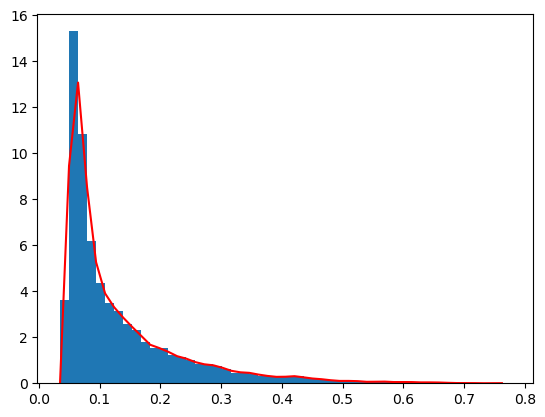

In [20]:
mean_bin = np.zeros(pdf_mean[1].shape[0]-1)
for i in range(pdf_mean[1].shape[0]-1) : mean_bin[i] = (pdf_mean[1][i+1] + pdf_mean[1][i])/2
f_pdf = interpolate.interp1d(mean_bin, pdf_mean[0],bounds_error = False, fill_value = (0,0))

plt.bar(pdf_mean[1][:-1], pdf_mean[0], width=np.diff(pdf_mean[1]), align='edge')
plt.plot(pdf_mean[1][:-1], f_pdf(pdf_mean[1][:-1]), c ='r')

In [21]:
np.save('./data/set1/pdf_mean.npy', np.array(pdf_mean, dtype=object), allow_pickle=True)

# Method 2, Create a histogram for each frequency

In [22]:
def create_pdfs(t,freq,N):
    GLS = np.zeros((freq.shape[0], N) )
    
    A1, A2, A3  = 0.027*1e6, 0.003*1e6, 0.3*1e-3*1e6 # m/s
    B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
    C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
    AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
    cste        = 1.4e-4 # (m/s)**2/Hz

    params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]
    
    for i in range(N):
        
        Prot = random.randint(5,90)#62 # days -- Prot to be chosen randomly in HARPS sample (see paper)
        amp  = gamma.rvs(2.0, 0.5) 
        epsilon = uniform.rvs(0.5, 1)
        tau = np.random.normal(3*Prot, 0.1*Prot) 
        params_act = [tau, epsilon, Prot, amp]
        
        y,eb = generate_data_H0(params_gr, params_act,t)
        gls = LombScargle(t,y,eb).power(freq,method='cython')
        GLS[:,i] = gls
    
    pdfs = []
    for k in range(freq.shape[0]):
        pdfs.append(np.histogram( GLS[k,:], bins = 50, density = True))
        
    # plt.bar(hist[1][:-1], hist[0], width=np.diff(hist[1]), align='edge') to plot
    return pdfs # y,x

In [23]:
pdfs = create_pdfs(t,freq,50000)

In [24]:
np.save('./data/set1/pdfs.npy', np.array(pdfs, dtype=object), allow_pickle=True)

<BarContainer object of 50 artists>

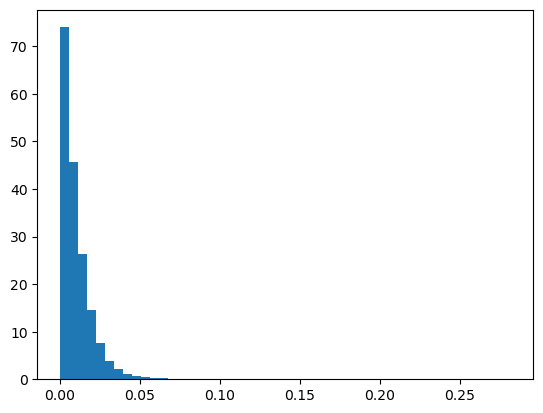

In [25]:
ind = 200
plt.bar(pdfs[ind][1][:-1], pdfs[ind][0], width=np.diff(pdfs[ind][1]), align='edge')

###  Method 1 with fixed GP Parameters

In [27]:
def create_pdf_fixedGP(t,freq,N):
    amps = np.zeros(N)
    
    A1, A2, A3  = 0.027*1e6, 0.003*1e6, 0.3*1e-3*1e6 # m/s
    B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
    C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
    AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
    cste        = 1.4e-4 # (m/s)**2/Hz

    params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]
    
    for i in range(N):
        
        Prot = 20#random.randint(5,90)#62 # days -- Prot to be chosen randomly in HARPS sample (see paper
        amp  = 0.5#gamma.rvs(2.0, 0.5) 
        epsilon = 0.5#uniform.rvs(0.5, 1)
        tau = Prot/2
        params_act = [tau, epsilon, Prot, amp]
        
        y,eb = generate_data_H0(params_gr, params_act,t)
        ls = LombScargle(t,y,eb).power(freq,method='cython')
        amps[i] = max(ls)
        
    pdf = np.histogram(amps, bins = 50, density = True)
    # plt.bar(hist[1][:-1], hist[0], width=np.diff(hist[1]), align='edge') to plot
    return pdf # y,x

In [28]:
pdf_mean_fixedGP = create_pdf_fixedGP(t,freq,20000)

In [33]:
np.save('./data/set3/pdf_mean_fixedGP.npy', np.array(pdf_mean_fixedGP, dtype=object), allow_pickle=True)

# Create a histogram for each frequency with fixed GP parameters

In [30]:
def create_pdfs_fixedGP(t,freq,N):
    
    GLS = np.zeros((freq.shape[0], N) )
    
    A1, A2, A3  = 0.027*1e6, 0.003*1e6, 0.3*1e-3*1e6 # m/s
    B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
    C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
    AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
    cste        = 1.4e-4 # (m/s)**2/Hz

    params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]
    
    for i in range(N):
        
        Prot = 20 # days 
        amp  = 0.5
        epsilon = 0.5
        tau = Prot/2
        params_act = [tau, epsilon, Prot, amp]
        
        y,eb = generate_data_H0(params_gr, params_act,t)
        gls = LombScargle(t,y,eb).power(freq,method='cython')
        GLS[:,i] = gls
    
    pdfs = []
    for k in range(freq.shape[0]):
        pdfs.append(np.histogram( GLS[k,:], bins = 50, density = True))
    
    
    # plt.bar(hist[1][:-1], hist[0], width=np.diff(hist[1]), align='edge') to plot
    return pdfs, GLS # y,x

In [31]:
pdfs_fixedGP, GLS = create_pdfs_fixedGP(t,freq,50000)

In [32]:
np.save('./data/set3/pdfs_fixedGP.npy', np.array(pdfs_fixedGP, dtype=object), allow_pickle=True)

<BarContainer object of 50 artists>

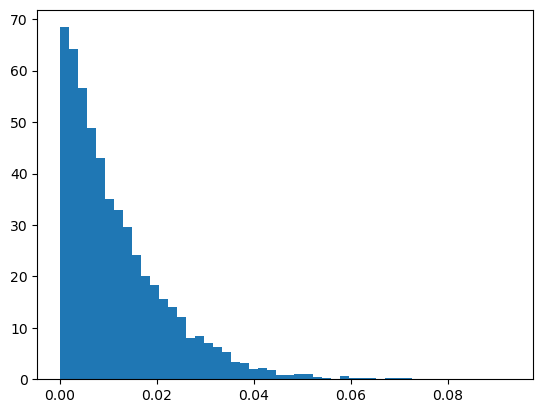

In [32]:
ind = 880
plt.bar(pdfs_fixedGP[ind][1][:-1], pdfs_fixedGP[ind][0], width=np.diff(pdfs_fixedGP[ind][1]), align='edge')

In [27]:
GLS_mean = np.mean(GLS, axis = 1)

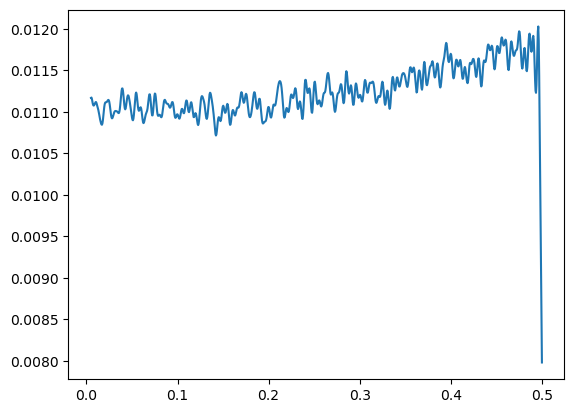

In [28]:
plt.plot(freq,GLS_mean)

In [29]:
GLS_mean

array([0.01116797, 0.01117221, 0.01115441, 0.01112337, 0.01109494,
       0.0110789 , 0.01107561, 0.01108139, 0.0110928 , 0.0111064 ,
       0.01111686, 0.01111785, 0.01110627, 0.01108575, 0.01106364,
       0.01104369, 0.01102335, 0.01099813, 0.01096745, 0.01093522,
       0.01090588, 0.01088121, 0.01086115, 0.01084724, 0.01084465,
       0.01085994, 0.01089612, 0.01094875, 0.01100666, 0.01105719,
       0.011092  , 0.01110977, 0.01111513, 0.01111536, 0.01111672,
       0.01112206, 0.01113074, 0.01113956, 0.01114399, 0.0111392 ,
       0.01112136, 0.01108932, 0.01104632, 0.01099993, 0.01095953,
       0.01093245, 0.01092161, 0.01092566, 0.0109404 , 0.01096035,
       0.01098012, 0.01099572, 0.01100538, 0.01100967, 0.0110105 ,
       0.01100969, 0.01100794, 0.01100484, 0.01099969, 0.01099269,
       0.01098614, 0.01098515, 0.01099674, 0.01102669, 0.01107562,
       0.01113727, 0.01120013, 0.01125136, 0.01128059, 0.01128218,
       0.01125578, 0.01120651, 0.01114506, 0.01108625, 0.01104